# โค้ดสำหรับการวิเคราะห์ค่า correlation ระหว่างฝนสสน.กับฝนcappisตามระยะทาง
* ใช้จำนวนฝนรายเหตุการณ์ของปี 2018 
* หาจำนวนสถานีวัดฝนภาคพื้นดินตามระยะทาง [40,80,120,160,200,240 km] ส่งออกเป็น csv
* ดึงข้อมูลของฝนสถานีรายชั่วโมงตามระยะทางด้วยการอ่าน csv เข้ามา เก็บไว้ตามโฟลเดอร์ที่สร้างไว้
* สกัดฝนสถานีกับฝนเรดาร์ตามระยะทาง ส่งออกเป็นไฟล์ csv
* หาค่า correlation matrix ของตัวแปรที่สกัดมาได้
* พลอตกราฟ correlation ตามระยะทางของฝนเรดาร์
* หมายเหตุ: ฝนรายชั่วโมงมาจาก max dBZ ในชั่วโมงนั้น ๆ 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
#import fiona #ใช้เพื่อส่งออกไฟล์
#from matplotlib_scalebar.scalebar import ScaleBar
import warnings
warnings.filterwarnings('ignore')

import requests, os
#from math import radians, cos, sin, asin, sqrt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from dateutil import rrule
from pathlib import Path

import rasterio
import os

from functools import reduce
import seaborn as sns

# หาจำนวนสถานีวัดฝนภาคพื้นดินตามระยะทางส่งออกเป็น csv

In [2]:
def find_gauge_in_radar(dist_km,dir_gauge,fn_ga_dist):
    '''
    หาสถานีวัดฝน สสน. ภายใต้รัศมีของสถานีเรดาร์
    '''
    buff_dist_m = dist_km*1000
    
    #อ่านสถานีฝนสสน.
    df = pd.read_csv('../0data/station_metadata_haii_geographic.csv')
    fn_out = dir_gauge+fn_ga_dist+str(dist_km)+'km.csv'

    #แปลงตำแหน่งสถานีวัดน้ำให้เป็น geopandas dataframe
    crs = {'init':'EPSG:4326'}
    geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
    geo_df_st = gpd.GeoDataFrame(df, 
                              crs = crs, 
                              geometry = geometry)

    #สถานีเรดาร์พิษณุโลก
    df_rd = pd.DataFrame(
        {
            "City": ["Phitsanulok"],
            "Latitude": [16.775365],
            "Longitude": [100.217971],
        }
    )
    gdf_rd = gpd.GeoDataFrame(
        df_rd, geometry=gpd.points_from_xy(df_rd.Longitude, df_rd.Latitude), crs="EPSG:4326"
    )

    #สร้างบัฟเฟอร์ตามระยะทาง  UTM 47N
    buffer = gdf_rd.to_crs(epsg=32647).buffer(buff_dist_m) # เมตร

    #ใช้ Spatial Joins เพื่อนับจำนวนสถานีวัดฝนในเรดาร์พิษณุโลก
    geo_df_buffer = gpd.GeoDataFrame(geometry=buffer)
    geo_df_GaugeInBuffer = gpd.sjoin(geo_df_st.to_crs(epsg=32647), geo_df_buffer, how="inner", op='intersects')

    # เซฟไฟล์สถานีในเรดาร์พิษณุโลกออกไปเป็น shape / csv
    #geo_df_GaugeInBuffer.to_file('./0results/0rain_hour_by_dist/GaugeInBuffer_radar_phitsanulok_240km.shp')  
    geo_df_GaugeInBuffer.to_csv(fn_out)  

### หาจำนวนจุดสถานีภายใต้รัศมีเรดาร์

In [3]:
dist = [40,80,120,160,200,240] #รัศมีเรดาร์ที่ต้องการ km
dir_gauge = './00Results/00rain_hour_by_dist_downloaded_all_events/' #ต้องสร้างโฟลเดอร์ไว้ก่อน
fn_ga_dist= 'GaugeInBuffer_radar_phitsanulok_'

for ct,dist_km in enumerate(dist):
    print('>..หาสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์ ',str(dist_km)+'   km')
    
    # เรียกฟังก์ชั่นเพื่อหาจำนวนจุดสถานีภายใต้รัศมีเรดาร์
    find_gauge_in_radar(dist_km,dir_gauge,fn_ga_dist)   
    

>..หาสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  40   km
>..หาสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  80   km
>..หาสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  120   km
>..หาสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  160   km
>..หาสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  200   km
>..หาสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  240   km


# ดึงข้อมูลของฝนสถานีรายชั่วโมงตามระยะทางด้วยการอ่าน csv เข้ามา เก็บไว้ตามโฟลเดอร์ที่สร้างไว้

In [4]:
# ฟังก์ชั่นดึงข้อมูลฝนจากสสน.
#คำสั่งนี้ใช้เรียกปริมาณน้ำฝนแบบรายวันจาก URL ของสถาบันสารสนเทศทรัพยากรน้ำ (องค์การมหาชน)
def get_rainfall_hii(df_filter, start, end, path_output):
  url_source = 'https://tiservice.hii.or.th/opendata/data_catalog/hourly_rain/' 
  #path_output = '../0test/0results/0rain_hour_by_dist/'

  #date_start = datetime.strptime(start + '-01', '%Y-%m-%d')
  #date_end = datetime.strptime(end + '-01', '%Y-%m-%d')

  date_start = datetime.strptime(start, '%Y-%m-%d')
  date_end = datetime.strptime(end, '%Y-%m-%d')

  condition = rrule.rrule(rrule.MONTHLY, dtstart=date_start, until=date_end)
  total_process = condition.count()
  i = 1

  for date in condition:
    print('========== Start process (' + str(i) + '/' + str(total_process) + '): ' + date.strftime('%Y-%m') + ' ==========')
    year = date.strftime('%Y')
    month = date.strftime('%m')

    path = path_output + year + '/' + month
    Path(path).mkdir(parents=True, exist_ok=True)

    for code in df_filter['code']:
      # print(code)

      url = url_source + year + '/' + year + month + '/' + code.strip() + '.csv'

      # Download and save file
      result = requests.get(url)
      if result.status_code == 200:
        file_path = Path(path + '/' + code.strip() + '.csv')
        file_path.write_bytes(result.content)
        # print('Downloaded: ' + year + '/' + month + '/' + code.strip())
      else:
        print('Failed: '  + year + '/' + month + '/' + code.strip())
    i += 1

In [5]:
def sort_rain2hourly(start,end, path_output,out_rain_hr_path, dt_txt):
    '''
    ดึงฝนแต่ละชั่วโมงในวันที่ต้องการ แล้วส่งออกเป็น csv ในโฟลเดอร์ผลลัพธ์
    '''
    
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    condition = rrule.rrule(rrule.MONTHLY, dtstart=date_start, until=date_end)

    prec = [] #รวมฝนสถานีที่ดาวน์โหลดมาไว้ในลิสต์นี้

    for date in condition:
      year = date.strftime('%Y')
      month = date.strftime('%m')

      target = path_output + year + '/' + month + '/'

      for filename in os.listdir(target):
        station = filename.split('.')[0]
        df = pd.read_csv(target + filename)
        df['station'] = station
        prec.append(df)

    #ผลที่ได้คือ ฝนรายชั่วโมงของแต่ละสถานีในเดือนนั้น ๆ 
    #จัดข้อมูลฝนให้อยู่ใน dataframe เดียวกัน ดึงเฉพาะคอลัมน์ที่สนใจ
    prec_pd=pd.concat(prec).reset_index(drop=False)
    # get columns using dataframe subsetting
    rain_subset = prec_pd[['date','time', 'rain', 'station']]
    rain_subset['full_date']=rain_subset['date'].map(str)+'-'+rain_subset['time'].map(str)
    
    #ดึงฝนแต่ละชั่วโมงในวันที่ต้องการ แล้วส่งออกเป็น csv ในโฟลเดอร์ผลลัพธ์
    #dt_txt = ['2018-07-21-','2018-07-22-','2018-07-23-'] #ฝนรายชั่วโมงในวันที่ต้องการ
    hr_txt = rain_subset['time'].unique()

    #out_rain_hr_path = path_output_hr

    for d in dt_txt:
        #print
        for h in hr_txt:
            dh=d+h
            dt=datetime.strptime(dh, '%Y-%m-%d-%H:%M')
            #print(dh+'>>>')
            rain_ =rain_subset[rain_subset['full_date']==str(dh)]

            # qc 3 ค่า >> nan '-' -999.0
            df_rain_pl=rain_.merge(df_filter,left_on='station', right_on='code')        
            df_ = df_rain_pl.drop(df_rain_pl[df_rain_pl['rain'] == '-'].index)
            df_ = df_.drop(df_[df_['rain'] == -999.0].index)
            df_ = df_.dropna().reset_index(drop=True)              

            #ส่งออกฝนรายชั่วโมง csv
            file_hr = dt.strftime('%Y')+dt.strftime('%m')+dt.strftime('%d')+dt.strftime('%H')+'.csv'
            df_.to_csv(out_rain_hr_path + file_hr, encoding='utf-8-sig')

## โปรแกรมหลักเรียกฟังก์ชั่นมาสร้างไฟล์ฝนรายชั่วโมง

In [6]:
path_output = './00Results/00rain_hour_by_dist_downloaded_all_events/' #ต้องสร้างโฟลเดอร์ไว้ก่อน
path_output_hr='./00Results/00rain_hour_by_dist_final_all_events/' #ต้องสร้างโฟลเดอร์ไว้ก่อน

dist = [40,80,120,160,200,240] #km
dir_gauge = './00Results/00rain_hour_by_dist_downloaded_all_events/'
fn_ga_dist= 'GaugeInBuffer_radar_phitsanulok_'

dt_txt = ['2018-06-01-','2018-06-02-','2018-06-03-','2018-06-04-','2018-06-05-',
         '2018-06-06-','2018-06-07-','2018-06-08-','2018-06-09-','2018-06-10-',
         '2018-07-15-','2018-07-16-','2018-07-17-','2018-07-18-','2018-07-19-',
         '2018-07-20-','2018-07-21-','2018-07-22-','2018-07-23-','2018-07-24-',
         '2018-08-13-','2018-08-14-','2018-08-15-','2018-08-16-','2018-08-17-',
         '2018-08-18-','2018-08-19-','2018-08-20-','2018-08-21-','2018-08-22-',
         '2018-09-10-','2018-09-11-','2018-09-12-','2018-09-13-','2018-09-14-',
         '2018-09-15-','2018-09-16-','2018-09-17-','2018-09-18-','2018-09-19-',
         '2018-09-20-','2018-09-21-'] #ฝนรายชั่วโมงในวันที่ต้องการ

for ct,dist_km in enumerate(dist):
    print('>..ดึงสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์ ',str(dist_km)+'   km')
    fn_ga = dir_gauge+fn_ga_dist+str(dist_km)+'km.csv'
    path_out_ga = path_output+str(dist_km)+'km/'
    out_rain_hr_path = path_output_hr+str(dist_km)+'km/'
   
    
    # อ่านสถานีวัดฝนที่ตกอยู่ในเรดาร์พิษณุโลก
    df_pl = pd.read_csv(fn_ga)
    station_pl = df_pl['code']
    #station_pl

    # เรียก Station ของสสน.จาก URL 
    df_hii = pd.read_csv('https://tiservice.hii.or.th/opendata/data_catalog/daily_rain/station_metadata.csv')
    #df_hii.head()

    #เรียกข้อมูลสถานีที่อยู่ภายใต้เรดาร์พิษณุโลกจากสถานีทั้งหมดของสสน.
    # Strip whitespace in Column Code
    df_hii['code'] = df_hii['code'].str.strip()
    # Filter the DataFrame based on the list of stations
    df_filter = df_hii[df_hii['code'].isin(station_pl.str.strip())]
    #df_filter


    # กำหนดปีเดือนเริ่มต้นและวันที่สิ้นสุดที่ต้องการดึงข้อมูล
    start = '2018-06-01'
    end = '2018-09-22'
    
    
    #เรียกฟังก์ชั่นดึงข้อมูลฝนสสน.
    get_rainfall_hii(df_filter, start, end, path_out_ga)
    
    #เรียกฟังก์ชั่นจัดการข้อมูลที่ดาวน์โหลดมาให้อยู่ในลิสต์เดียวกัน
    print('>..จัดข้อมูลให้เป็นฝนรายชั่วโมงตามรัศมีเรดาร์')
    sort_rain2hourly(start,end, path_out_ga,out_rain_hr_path,dt_txt) 

print('\n.................completed download and sort file hourly gauge....................................\n')
    
    #find_gauge_in_radar(dist_km,dir_gauge,fn_ga_dist)   

>..ดึงสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  40   km
========== Start process (1/4): 2018-06 ==========
Failed: 2018/06/FOP022
========== Start process (2/4): 2018-07 ==========
Failed: 2018/07/FOP022
========== Start process (3/4): 2018-08 ==========
Failed: 2018/08/FOP022
========== Start process (4/4): 2018-09 ==========
Failed: 2018/09/FOP022
>..จัดข้อมูลให้เป็นฝนรายชั่วโมงตามรัศมีเรดาร์
>..ดึงสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  80   km
========== Start process (1/4): 2018-06 ==========
Failed: 2018/06/FOP022
Failed: 2018/06/KWN003
========== Start process (2/4): 2018-07 ==========
Failed: 2018/07/FOP022
Failed: 2018/07/KWN003
========== Start process (3/4): 2018-08 ==========
Failed: 2018/08/FOP022
Failed: 2018/08/KWN003
========== Start process (4/4): 2018-09 ==========
Failed: 2018/09/FOP022
Failed: 2018/09/KWN003
>..จัดข้อมูลให้เป็นฝนรายชั่วโมงตามรัศมีเรดาร์
>..ดึงสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  120   km
========== Start process (1/4): 2018-06 ==========
Failed: 2018/06/FOP056
Failed: 

# สกัดฝนเรดาร์กับฝนสถานี

In [7]:
def extract_dbz_by_stationRain(col_name,fn_rad,fn_ga,dir_rad,dir_ga):
    '''
    ฟังก์ชั่นที่จะใช้สกัดค่า dbz ตามพิกัดสถานีวัดน้ำฝน HAII แล้ว append ใน list
    '''
    crs = 'epsg:4326'  # Use this format for newer versions of GeoPandas
    dbz_rain = []
    for fn_r in fn_rad:
        for fn_g in fn_ga:
            if fn_r[:10] == fn_g[:10]:
                #print('> do extract dbz by location of gauge: ', fn_r[:10])

                # Read radar file
                rt = rasterio.open(dir_rad + fn_r)

                # Read rain gauge file
                df = pd.read_csv(dir_ga + fn_g)

                # Convert rain gauge positions to GeoDataFrame
                geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
                gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

                # Sample radar data at rain gauge locations
                gdf["value"] = [float(x) for x in rt.sample([(x, y) for x, y in zip(gdf["geometry"].x, gdf["geometry"].y)])]

                # Append GeoDataFrame to the list
                dbz_rain.append(gdf)

                # Close files
                rt.close()


    # Combine all GeoDataFrames into a single GeoDataFrame
    df=gpd.GeoDataFrame(pd.concat(dbz_rain, ignore_index=True), crs=crs)
    df.rename(columns={"value": col_name}, inplace=True) #เปลี่ยนชื่อคอลัมน์

    return df
   

In [8]:
main_path ='./00Results/00outp_cappi_ppi_hourly_phs2018/0train_val_models/cappi/'
dir_rad_paths = [main_path +'cappi1km/', main_path +'cappi2km/', 
                 main_path +'cappi3km/', main_path +'cappi4km/'] #เรดาร์ dbz ที่จะใช้เป็น features

path_output = './00Results/00rain_hour_by_dist_downloaded_all_events/'
path_output_hr='./00Results/00rain_hour_by_dist_final_all_events/'

dist = [40,80,120,160,200,240] #km
dir_gauge = './00Results/00rain_hour_by_dist_downloaded_all_events/'
fn_ga_dist= 'GaugeInBuffer_radar_phitsanulok_'

for ct,dist_km in enumerate(dist):
    print('>..สกัดฝนเรดาร์ด้วยสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์ ',str(dist_km)+'   km')
    fn_ga = dir_gauge+fn_ga_dist+str(dist_km)+'km.csv'
    path_out_ga = path_output+str(dist_km)+'km/'
    out_rain_hr_path = path_output_hr+str(dist_km)+'km/'
    #print(out_rain_hr_path)
    #print(fn_ga)
    
    dir_ga = out_rain_hr_path  #ฝนสถานี สสน. ที่จะใช้เป็น target
    fn_ga_app= []
    for file in os.listdir(dir_ga):
        if file.endswith('.csv'):
            fn_ga_app.append(file) ## ต้องตรวจสอบ ปริ้นท์ไฟล์นี้มาดู ว่าเข้าไปลูปในเดือนหรือไม่
    
    #-ลูปสกัดฝนเรดาร์
    gdf_rads=[]
    for ci, dir_rad in enumerate(dir_rad_paths):
        print('>extracting...', dir_rad)
        fn_rad = []

        for file in os.listdir(dir_rad):
            if file.endswith('.tif'):
                fn_rad.append(file)

        #สกัดฝน dbz ด้วย ฝนสถานี
        col_name=os.path.basename(dir_rad.rstrip('/'))
        ex_gdf_rad=extract_dbz_by_stationRain(col_name,fn_rad,fn_ga_app,dir_rad,dir_ga)
        gdf_rads.append(ex_gdf_rad)   

        print('..........................................................................\n')
    
    #-รวม geodataframe และเลือกคอลัมน์ที่ต้องการ
    print('>รวม geodataframe...\n')
    merge_columns = ['full_date', 'code'] #คอลัมน์ที่จะใช้เป็นตัว merge เลือกมา 2 อัน
    # Merge GeoDataFrames using functools.reduce
    merged_gdf = reduce(lambda left, right: pd.merge(left, right, on=merge_columns), gdf_rads) #รวม geodataframe ของค่า dbz ในแต่ละ cappis/ppis
    merged_gdf = merged_gdf[[os.path.basename(path.rstrip('/')) for path in dir_rad_paths]+['full_date', 'code', 'rain_x']]
    df_org = merged_gdf.loc[:, ~merged_gdf.columns.duplicated()] #ลบคอลัมน์ที่ซ้ำ
    #df = df_org
    #df
    
    # save to csv
    print('>save to csv...\n')
    outp_extracted='./00Results/00rain_radar_hourly_extracted_all_events/'
    fn_extracted = 'df_org_dbz_rain_test'+str(dist_km)+'km.csv'
    df_org.to_csv(outp_extracted+fn_extracted)
    print('..........................................................................\n\n')
    
    

>..สกัดฝนเรดาร์ด้วยสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  40   km
>extracting... ./00Results/00outp_cappi_ppi_hourly_phs2018/0train_val_models/cappi/cappi1km/
..........................................................................

>extracting... ./00Results/00outp_cappi_ppi_hourly_phs2018/0train_val_models/cappi/cappi2km/
..........................................................................

>extracting... ./00Results/00outp_cappi_ppi_hourly_phs2018/0train_val_models/cappi/cappi3km/
..........................................................................

>extracting... ./00Results/00outp_cappi_ppi_hourly_phs2018/0train_val_models/cappi/cappi4km/
..........................................................................

>รวม geodataframe...

>save to csv...

..........................................................................


>..สกัดฝนเรดาร์ด้วยสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  80   km
>extracting... ./00Results/00outp_cappi_ppi_hourly_phs2018/0train_val_models/cappi/cappi

# หาค่า correlation matrix ของตัวแปรที่สกัดมาได้

>..พลอตcorrelation matrixฝนเรดาร์ด้วยสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  40   km

........................completed ploting......................................\nn
>..พลอตcorrelation matrixฝนเรดาร์ด้วยสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  80   km

........................completed ploting......................................\nn
>..พลอตcorrelation matrixฝนเรดาร์ด้วยสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  120   km

........................completed ploting......................................\nn
>..พลอตcorrelation matrixฝนเรดาร์ด้วยสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  160   km

........................completed ploting......................................\nn
>..พลอตcorrelation matrixฝนเรดาร์ด้วยสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  200   km

........................completed ploting......................................\nn
>..พลอตcorrelation matrixฝนเรดาร์ด้วยสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์  240   km

........................completed ploting......................................\nn


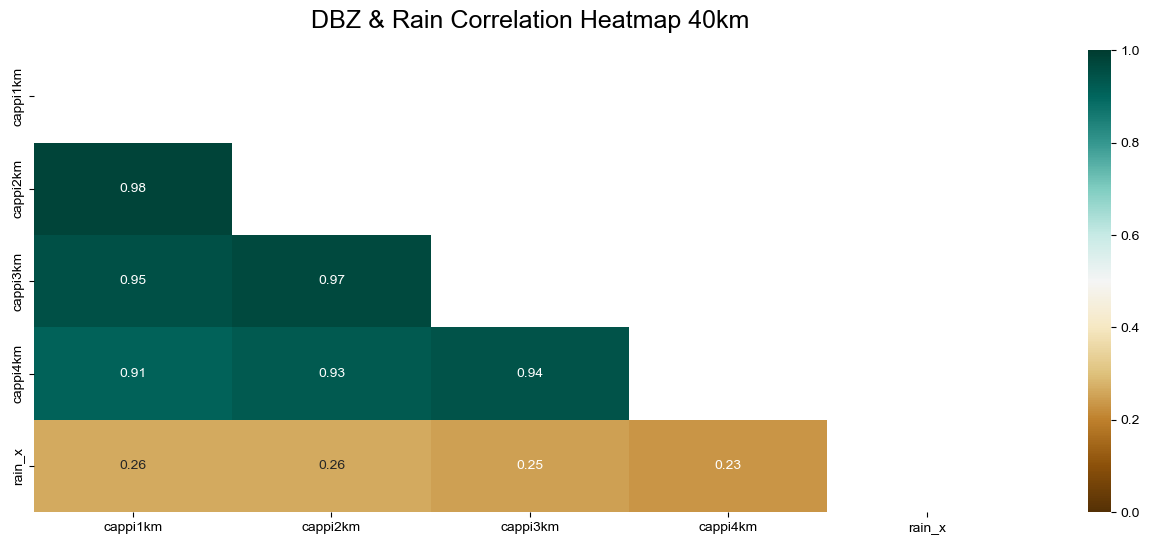

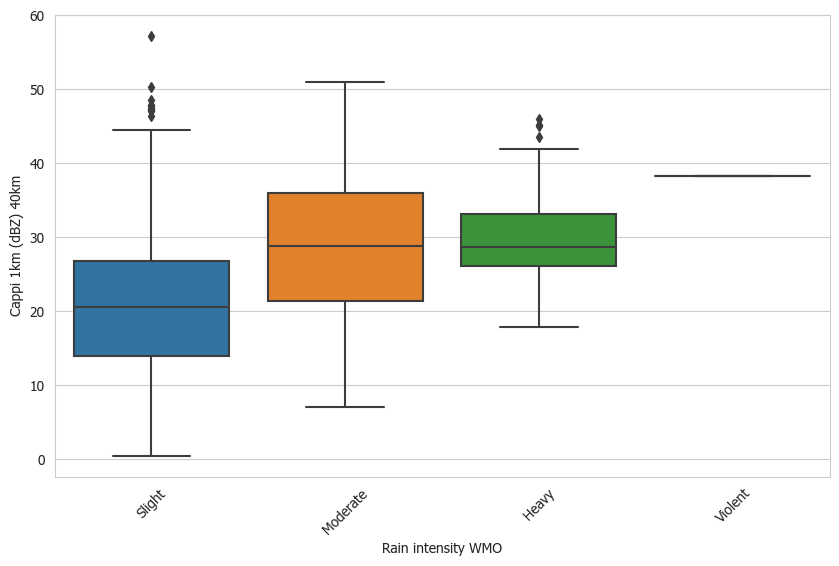

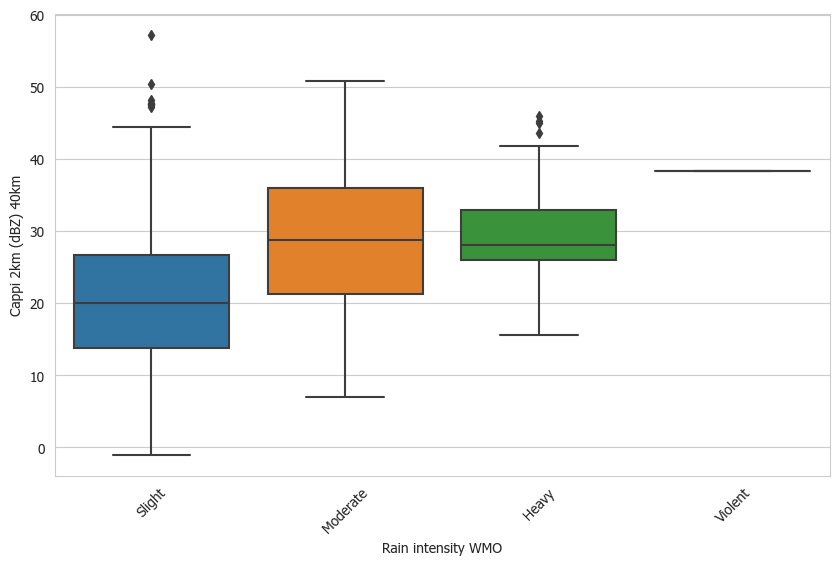

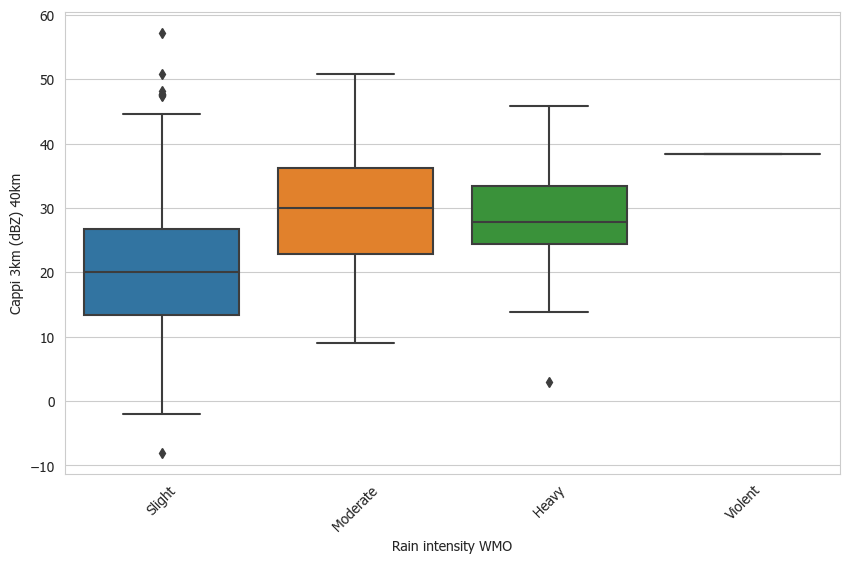

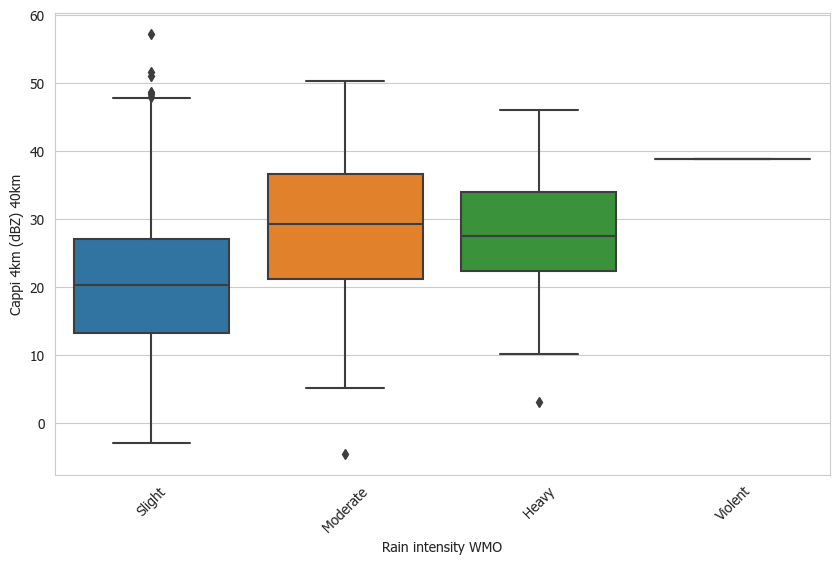

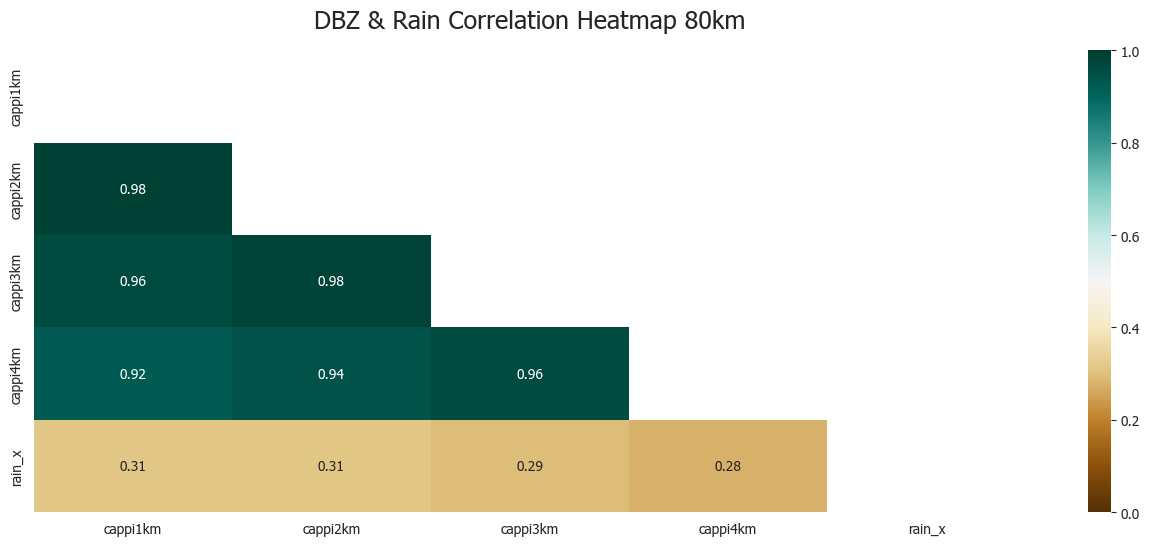

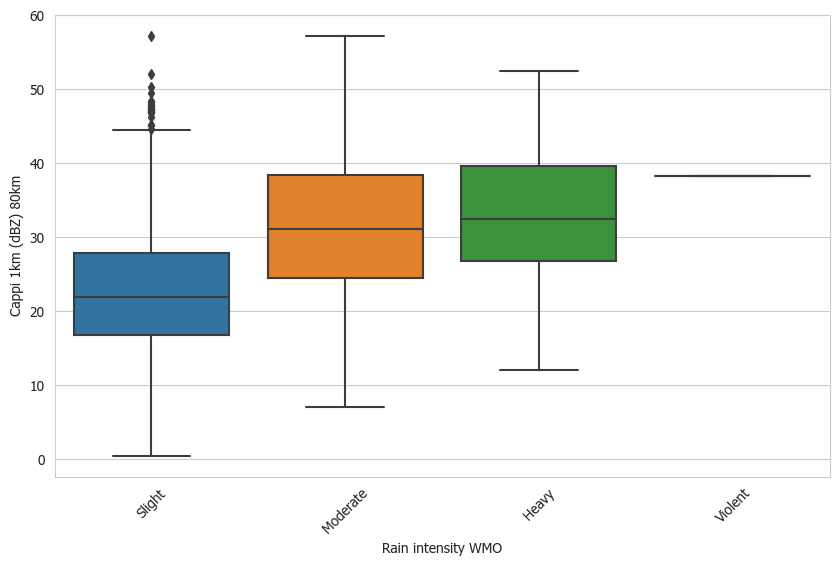

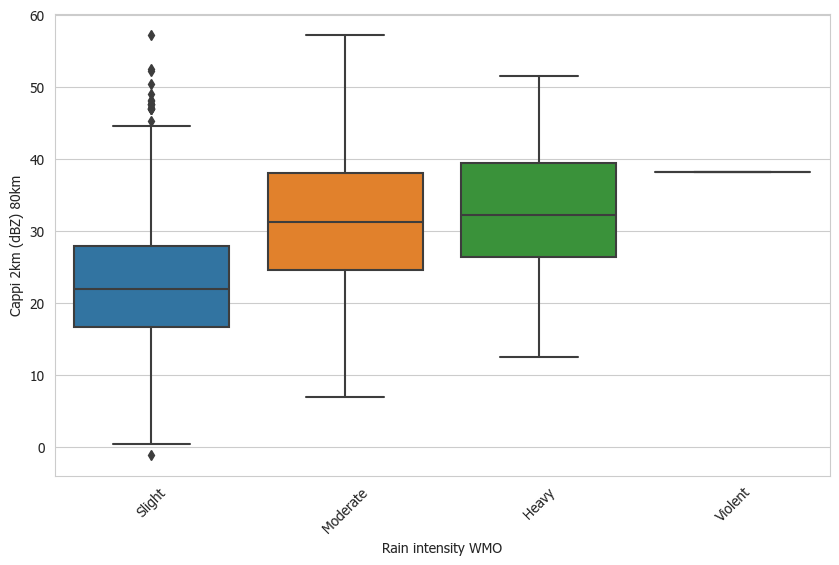

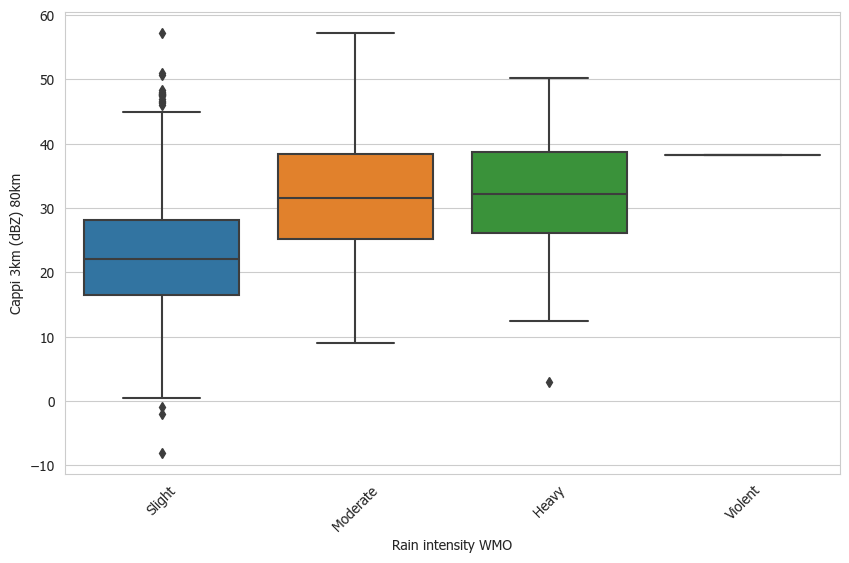

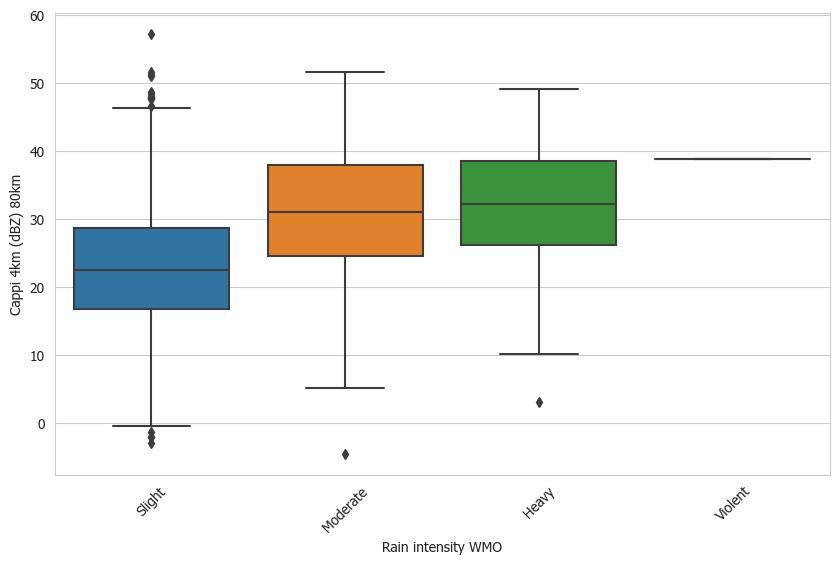

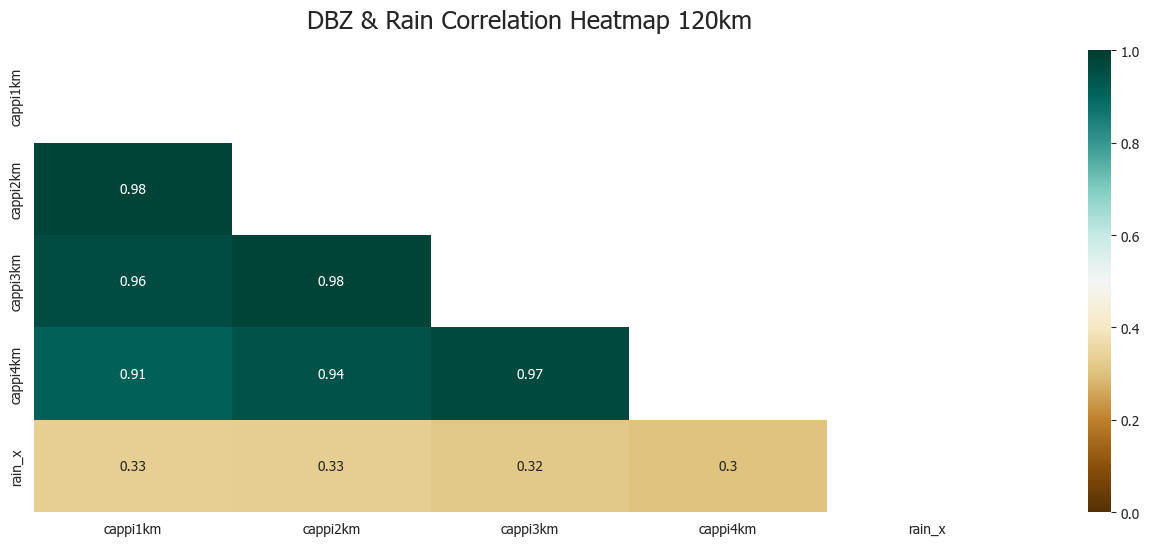

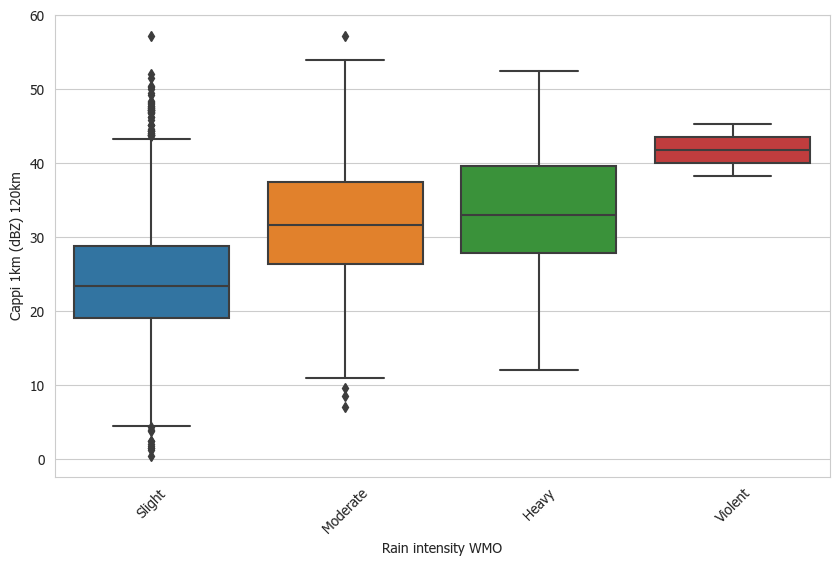

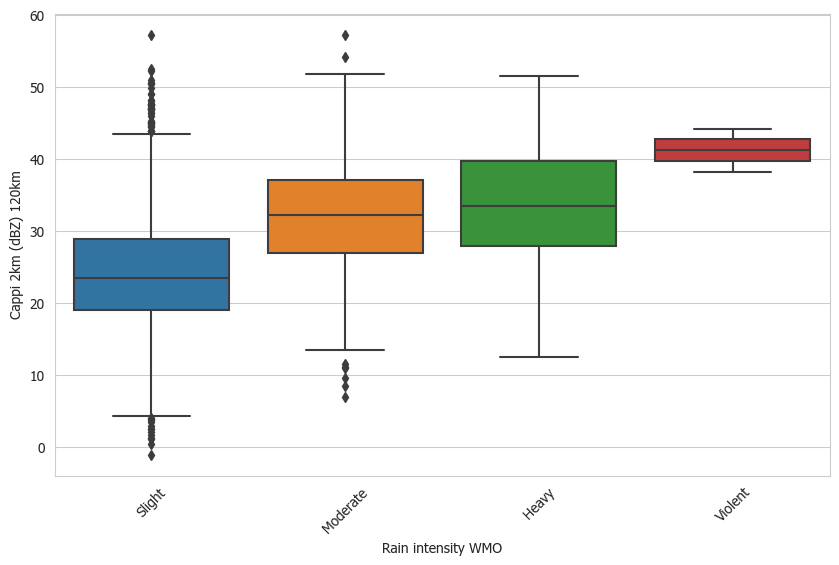

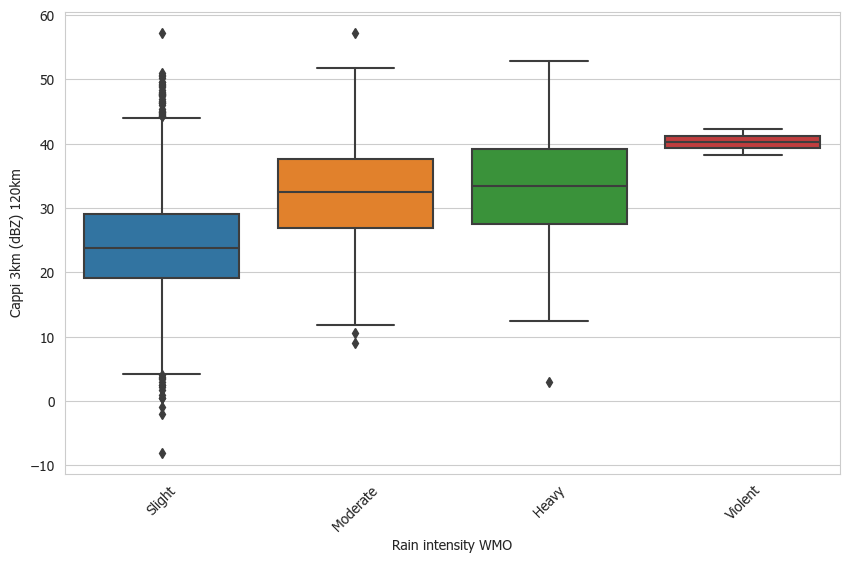

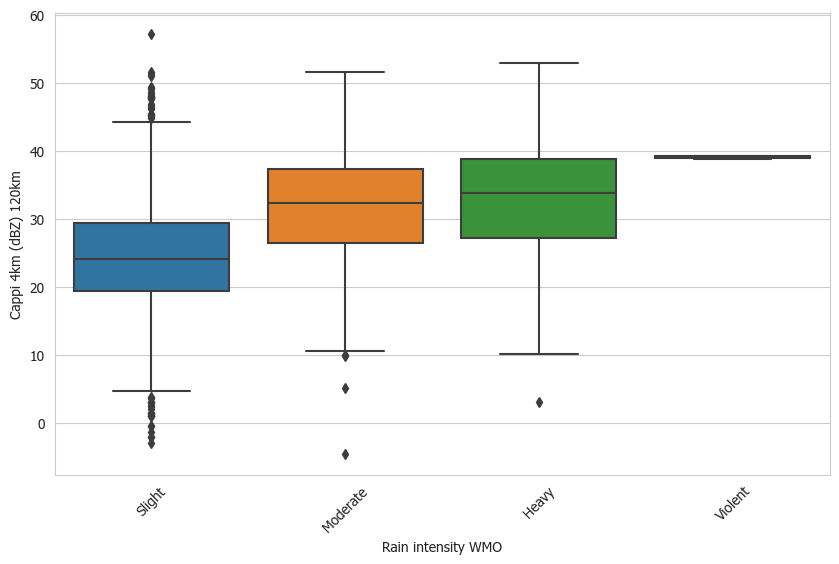

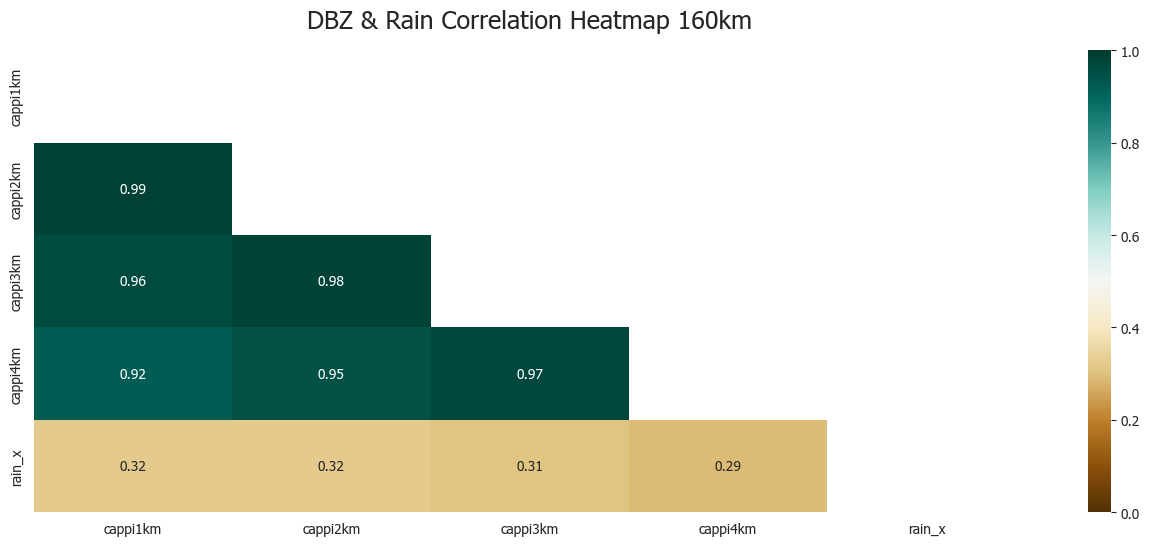

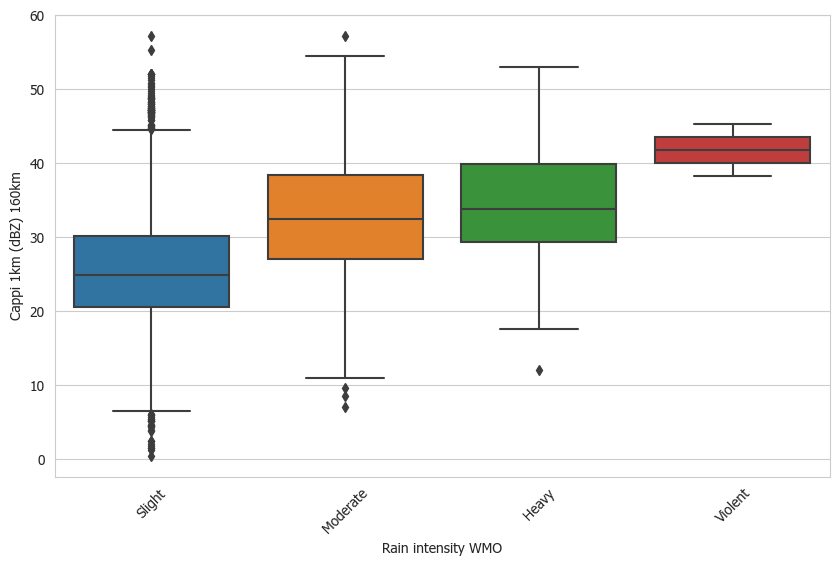

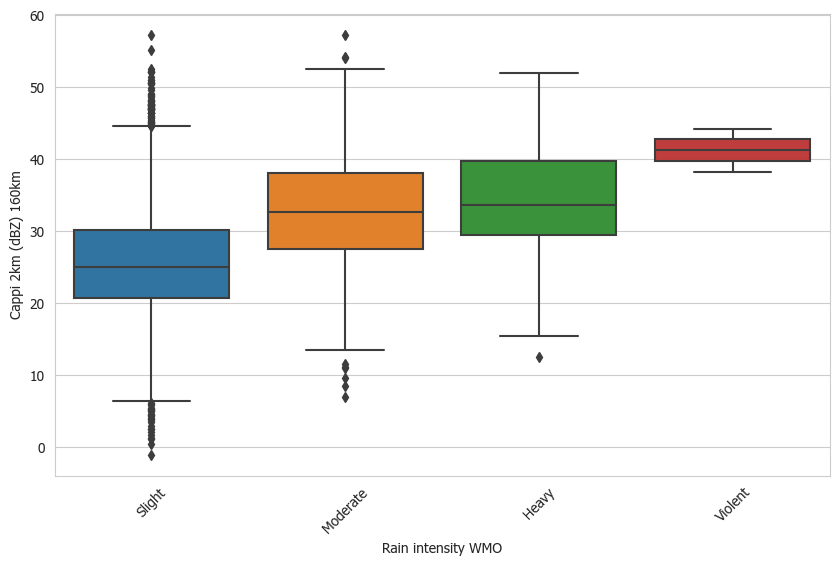

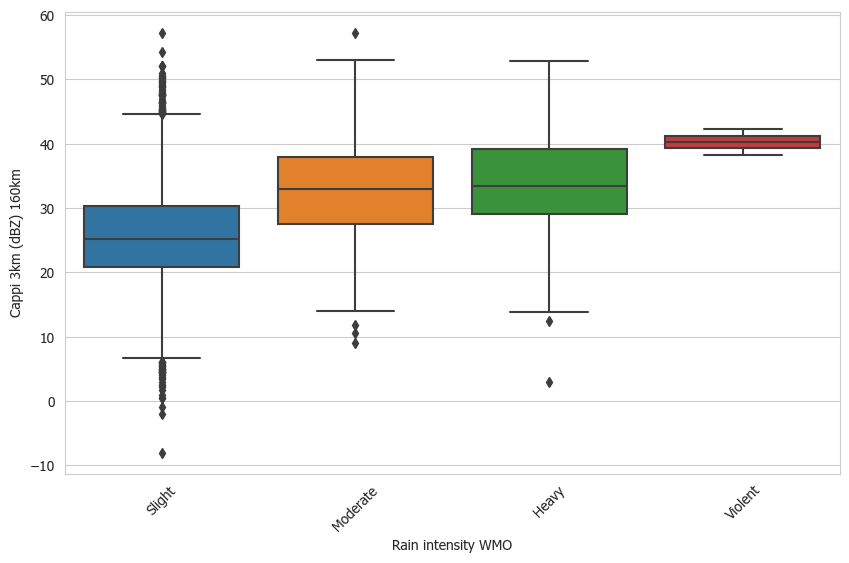

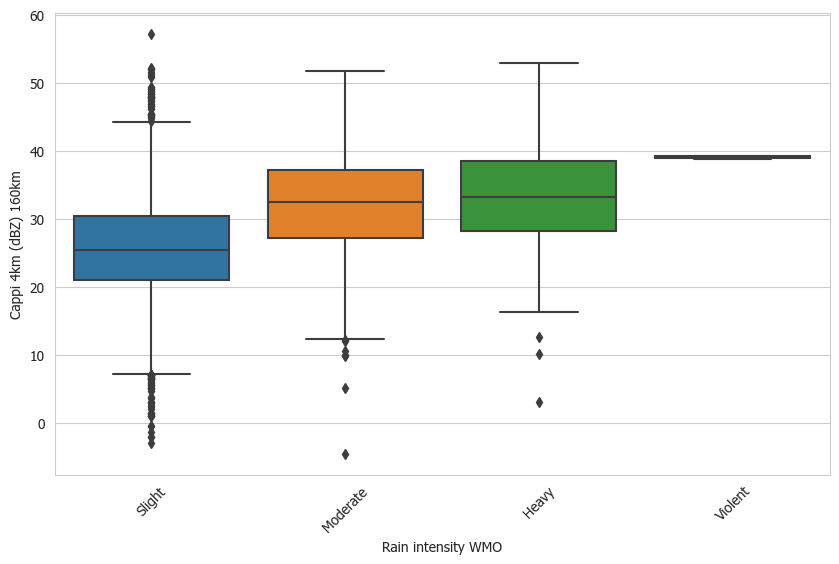

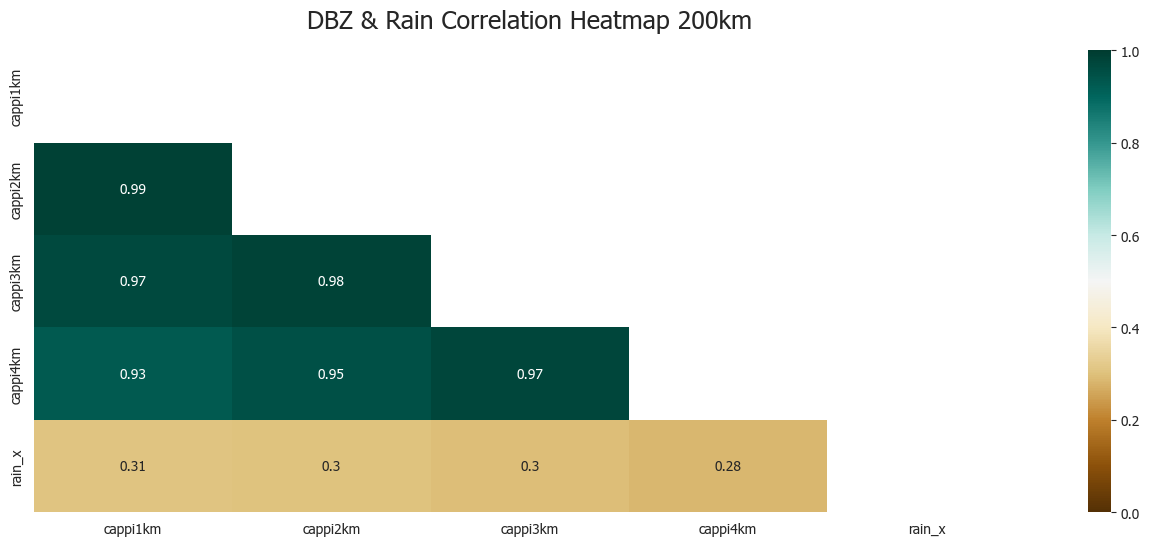

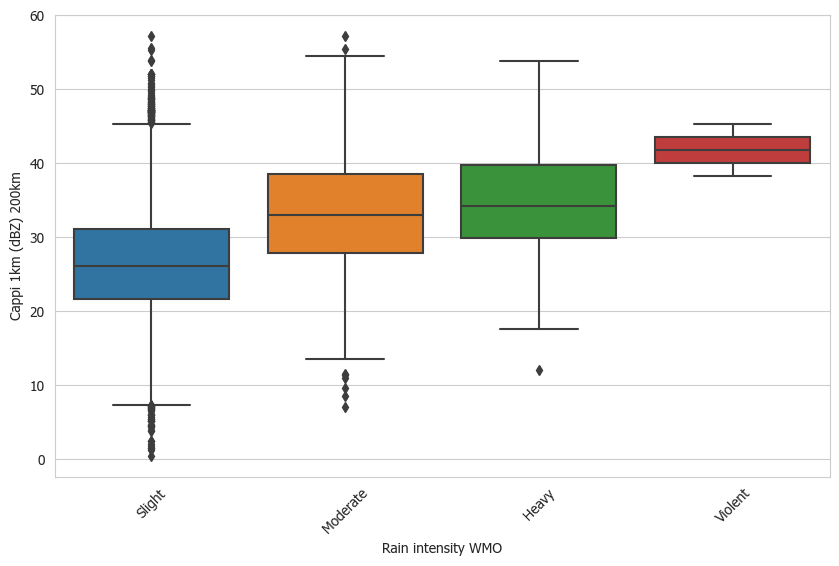

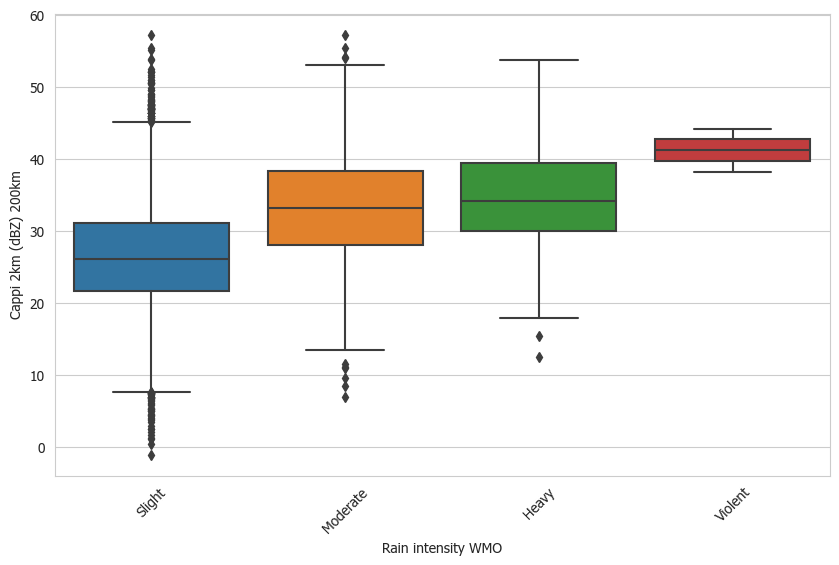

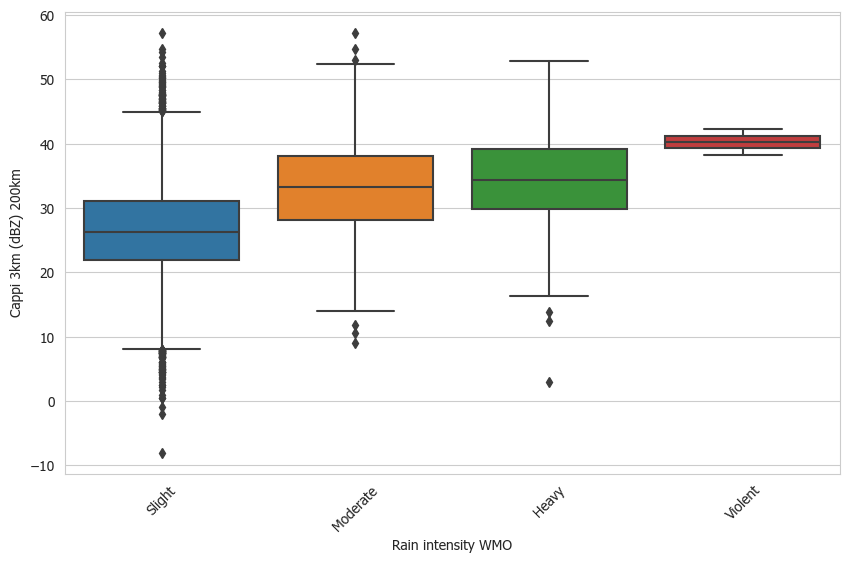

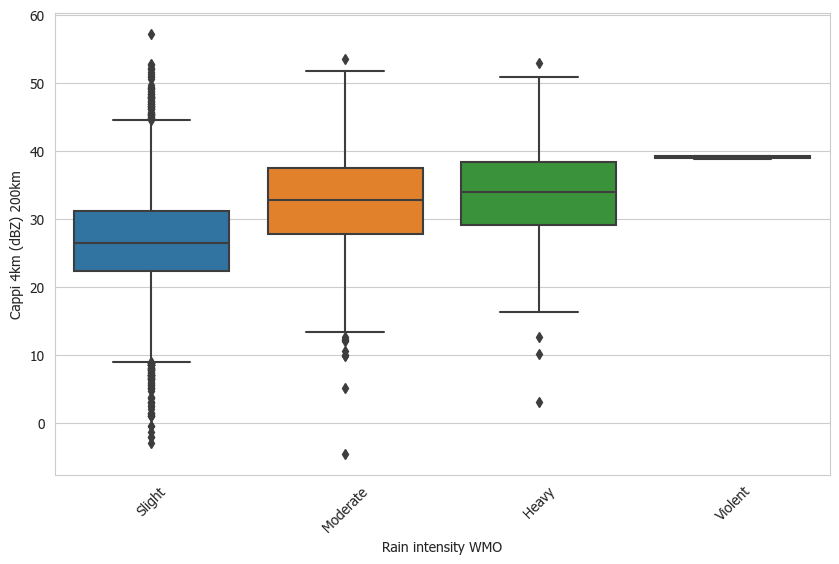

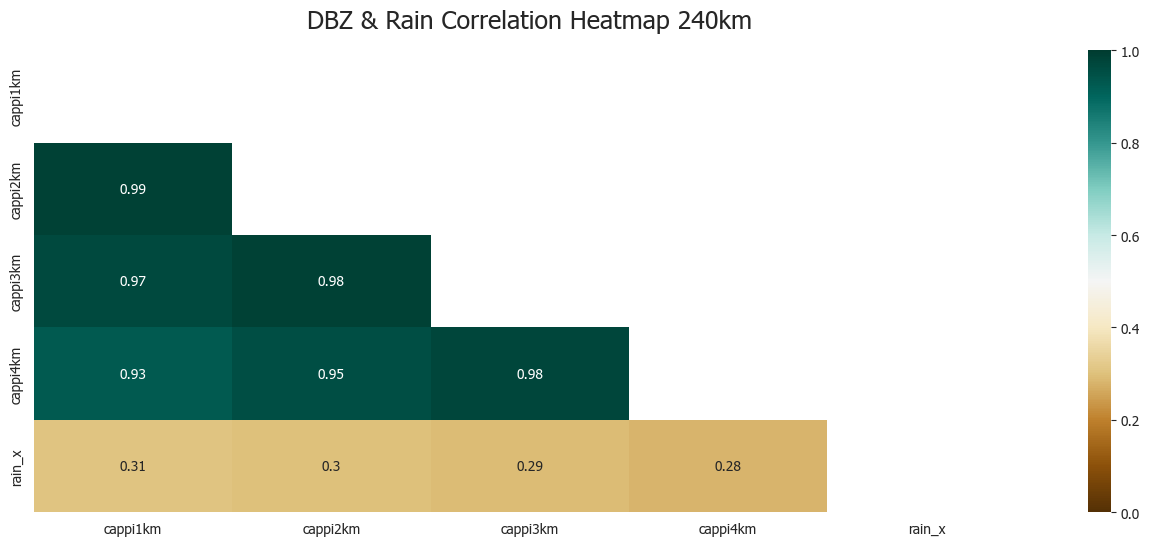

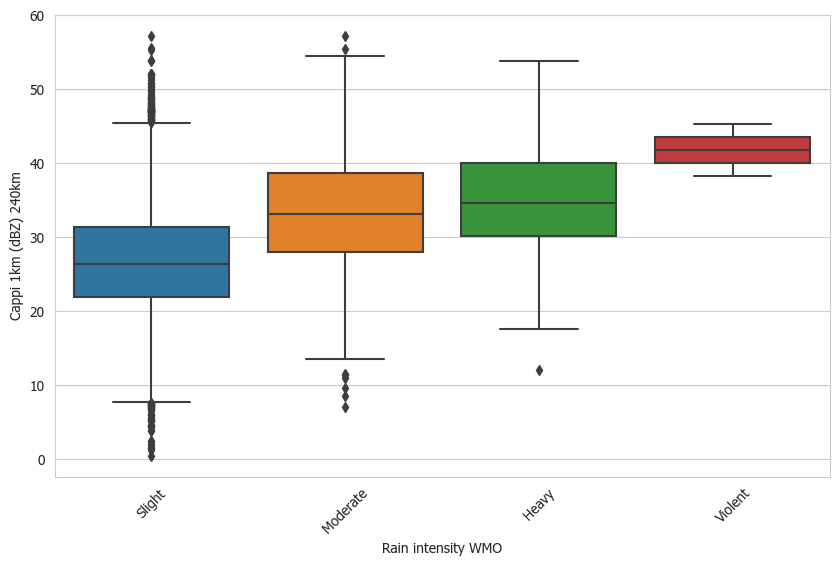

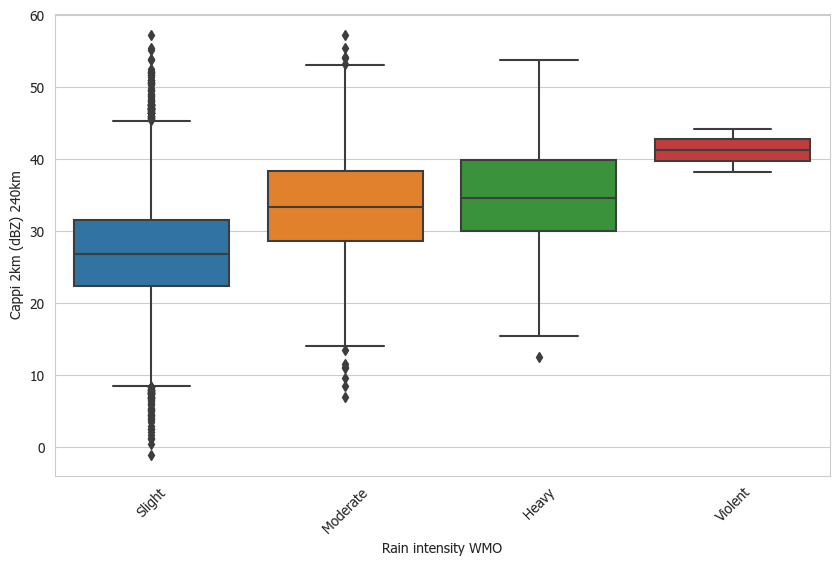

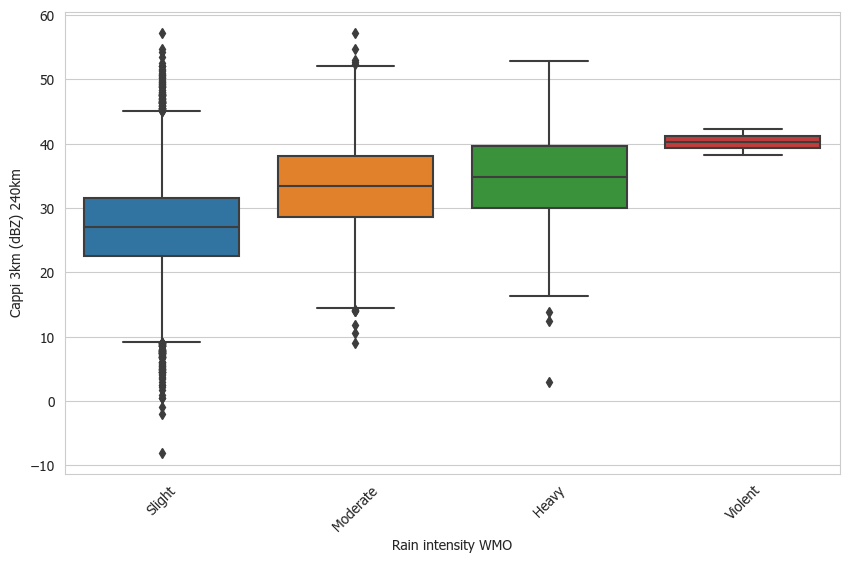

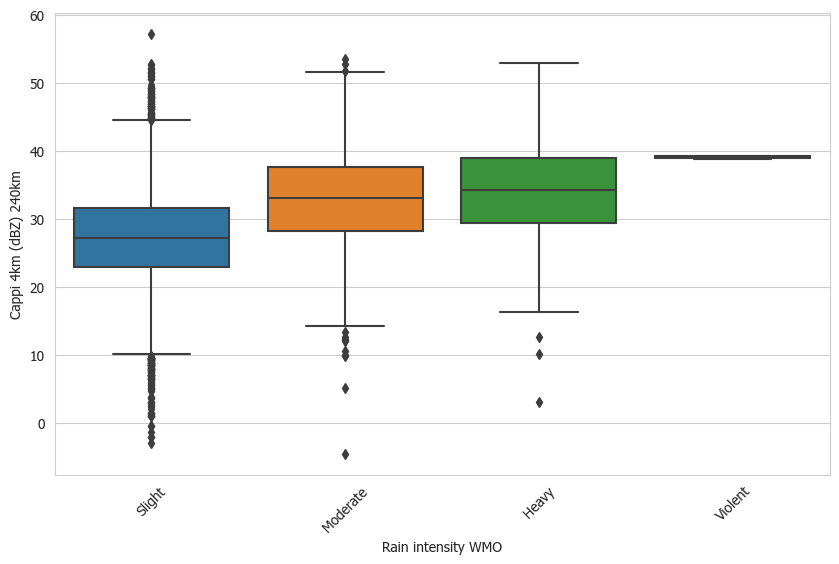

In [9]:
outp_extracted='./00Results/00rain_radar_hourly_extracted_all_events/'
rain_corr =[]

for ct,dist_km in enumerate(dist):
    print('>..พลอตcorrelation matrixฝนเรดาร์ด้วยสถานีวัดฝนสสน.ภายใต้รัศมีเรดาร์ ',str(dist_km)+'   km')
    fn_extracted = 'df_org_dbz_rain_test'+str(dist_km)+'km.csv'
    
    
    df = pd.read_csv(outp_extracted+fn_extracted)
    df.drop(df[df['rain_x'] <= 0].index, inplace = True)
    df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
    
    df['rain_intensity'] = 'Slight'
    df['rain_intensity'][df['rain_x'] <= 2.5] = 'Slight'
    df['rain_intensity'][(df['rain_x'] > 2.5) & (df['rain_x'] <= 10.0)] = 'Moderate'
    df['rain_intensity'][(df['rain_x'] > 10.0) & (df['rain_x'] <= 50.0)] = 'Heavy'
    df['rain_intensity'][df['rain_x'] > 50.0] = 'Violent'

    
    #พลอต correlation heatmap แบบ conditional rain
    plt.figure(figsize=(16, 6))
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    heatmap = sns.heatmap(df.corr(), mask=mask, vmin=0, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('DBZ & Rain Correlation Heatmap '+str(dist_km)+'km', fontdict={'fontsize':18}, pad=16);
    
    #เอาไปพลอตเปรียบเทียบตามระยะทาง
    rain_corr.append(df.corr().rain_x)
    
    
    #พลอต boxplot cappi1-4
    
    #-cappi1km
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")   
    sns.set_style({'font.family':'Tahoma'})
    bbplot=sns.boxplot(x ='rain_intensity' , y = 'cappi1km', data = df, order=['Slight', 'Moderate', 'Heavy', 'Violent']) 
    bbplot.set_xticklabels(bbplot.get_xticklabels(), rotation=45)
    bbplot.set(xlabel='Rain intensity WMO',  ylabel='Cappi 1km (dBZ) '+str(dist_km)+'km')
    
    #-cappi2km
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")   
    sns.set_style({'font.family':'Tahoma'})
    bbplot=sns.boxplot(x ='rain_intensity' , y = 'cappi2km', data = df, order=['Slight', 'Moderate', 'Heavy', 'Violent']) 
    bbplot.set_xticklabels(bbplot.get_xticklabels(), rotation=45)
    bbplot.set(xlabel='Rain intensity WMO',  ylabel='Cappi 2km (dBZ) '+str(dist_km)+'km')
    
    #-cappi3km
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")   
    sns.set_style({'font.family':'Tahoma'})
    bbplot=sns.boxplot(x ='rain_intensity' , y = 'cappi3km', data = df, order=['Slight', 'Moderate', 'Heavy', 'Violent']) 
    bbplot.set_xticklabels(bbplot.get_xticklabels(), rotation=45)
    bbplot.set(xlabel='Rain intensity WMO',  ylabel='Cappi 3km (dBZ) '+str(dist_km)+'km')
    
    #-cappi4km
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")   
    sns.set_style({'font.family':'Tahoma'})
    bbplot=sns.boxplot(x ='rain_intensity' , y = 'cappi4km', data = df, order=['Slight', 'Moderate', 'Heavy', 'Violent']) 
    bbplot.set_xticklabels(bbplot.get_xticklabels(), rotation=45)
    bbplot.set(xlabel='Rain intensity WMO',  ylabel='Cappi 4km (dBZ) '+str(dist_km)+'km')
    
    print('\n........................completed ploting......................................\\nn')

# พลอต correlation ตามระยะทาง

In [10]:
df=pd.concat(rain_corr,axis=1)
df

,rain_x,rain_x,rain_x,rain_x,rain_x,rain_x
cappi1km,0.262224,0.312956,0.332625,0.323860,0.306051,0.306550
cappi2km,0.261842,0.311180,0.329990,0.320662,0.303712,0.298498
cappi3km,0.248623,0.294750,0.318217,0.307351,0.295929,0.291862
cappi4km,0.233231,0.277084,0.301825,0.291277,0.281659,0.278388
rain_x,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df.columns=['40km', '80km','120km','160km','200km','240km']

In [12]:
df=df.iloc[:-1 , :] # drop last row

<AxesSubplot: >

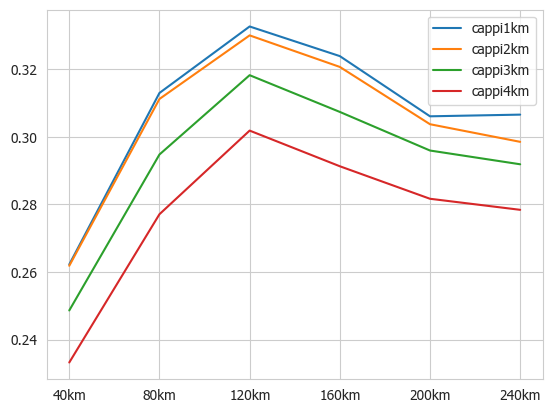

In [13]:
df.T.plot()

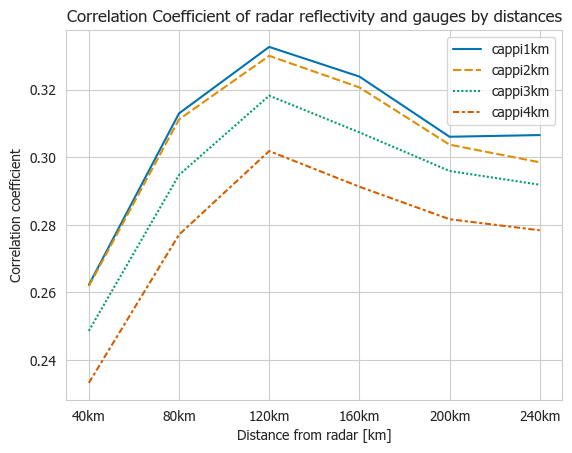

In [14]:
data=df.T
palette = sns.color_palette("colorblind", 10)
ax = sns.lineplot(data,palette=palette)
ax.set(xlabel='Distance from radar [km]', ylabel='Correlation coefficient')
plt.title('Correlation Coefficient of radar reflectivity and gauges by distances')
plt.show()

# สรุป
* หากใช้ฝน ทุกเหตุการณ์พบว่า ระยะทาง 120 km มีค่าสหสัมพันธ์ดีที่สุด อย่างไรก็ดีค่าความสัมพันธ์ค่อยลดต่ำลง เนื่องจากหากระยะทางไกลออกไปจากสถานี ความสูงของเรดาร์บีมจะสูงขึ้น ทำให้ความสัมพันธ์ระหว่างฝนประมาณค่ากับฝนภาคพื้นดินต่ำลง
* หากจะให้ผลดี ควรที่ 120 km อย่างไรก็ดีสามารถนำระยะทางที่ 200 km มาใช้ในการทดสอบการสร้าง ML ได้ เนื่องจากค่าสหสัมพันธ์ไม่ได้ลดลงมากนัก เมื่อเทียบกับระยะทางที่ 120 km ในทุกระดับความสูง อีกทั้งการใช้ที่ระยะ 200 km จะช่วยทำให้ได้ระยะทางในการสังกเกตุการณ์ที่กว้างกว่าการใช้ที่ระยะ 120 km

